# Causal Analysis: Effect of Pollen on Math Test Score - leveraging Dynamic Double Machine Learning from EconML


The dataset contains the studnets test score and pollen data for consecutive years obtaining the panel data structure. The goal is to find the effect of pollen on math test score.

Rationale: Some students suffer from seasonal pollen allergy and pollen might affect their test score, as their cognitive function might be affected by the allergy. This analysis aims to estimate the causal effect of pollen exposure on math test scores, accounting for potential heterogeneity

**Why I use DDML rather than Metaleaner or DML**
- DDML can take panel data as input and I happened to have a panel data. However, this project is dependent on an assumption that there is no cofounding variable that is not observed  (i.e., there are no unobserved confounders affecting both the treatment and the outcome)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import econml

In [2]:
df = pd.read_csv('pollen.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211375 entries, 0 to 1211374
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   year          1211375 non-null  int64  
 1   school_id     1211375 non-null  float64
 2   grade         1211375 non-null  float64
 3   sex           1211375 non-null  int64  
 4   id            1211375 non-null  float64
 5   math_level    1211143 non-null  float64
 6   kokugo_level  1211008 non-null  float64
 7   eng_level     369236 non-null   float64
 8   pollen        1211375 non-null  int64  
 9   lnPollen      1211375 non-null  float64
 10  tutor         1211375 non-null  object 
 11  books         1000900 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 110.9+ MB


In [8]:
df.isna().sum()

year                 0
school_id            0
grade                0
sex                  0
id                   0
math_level         232
kokugo_level       367
eng_level       842139
pollen               0
lnPollen             0
tutor                0
books           210475
dtype: int64

**Explanation of Variables We Use**
- id: student id (id is unique to each student)
- year: year
- school_id: school id (school_id is unique to each school)
- grade: grade of student at the time of exam
- sex: 0 male, 1 female
- pollen: pollen level (pollen/m3) at the nearest measurement station from each school the student attends
- lnPollen: log transformed pollen level
- math_level: math test score
- tutor (tutoring): whether the studnet takes tutoring or not - 0 no, 1 yes
- books: number of books at hom

In [3]:
# convert the tutor column to binary
df['tutor'] = df['tutor'].apply(lambda x: 1 if x == 'yes' else 0)

### EDA
note: data cleaing is done already as this data is from a previous project (undergraduate reserach project)|

In [5]:
df.describe()

,year,school_id,grade,sex,id,math_level,kokugo_level,eng_level,pollen,lnPollen,tutor,books
count,1.211375e+06,1.211375e+06,1.211375e+06,1.211375e+06,1.211375e+06,1.211143e+06,1.211008e+06,369236.000000,1.211375e+06,1.211375e+06,1.211375e+06,1.000900e+06
mean,2.017066e+03,1.977597e+04,6.392628e+00,4.914374e-01,1.331166e+06,1.334239e-01,1.268873e-01,0.449828,7.752953e+02,5.890890e+00,5.531078e-01,2.978433e+00
std,1.382658e+00,9.906829e+03,1.669601e+00,4.999269e-01,1.003651e+06,1.240588e+00,1.646119e+00,1.238895,1.059627e+03,1.559722e+00,4.971718e-01,1.199156e+00
min,2.015000e+03,1.000100e+04,4.000000e+00,0.000000e+00,8.000010e+05,-4.000000e+00,-5.327222e+00,-2.058584,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.016000e+03,1.034400e+04,5.000000e+00,0.000000e+00,1.036309e+06,-7.018530e-01,-9.416830e-01,-0.425426,3.240000e+02,5.783825e+00,0.000000e+00,2.000000e+00
50%,2.017000e+03,1.068500e+04,6.000000e+00,0.000000e+00,1.210488e+06,6.908483e-02,2.148800e-01,0.329995,3.780000e+02,5.937536e+00,1.000000e+00,3.000000e+00
75%,2.018000e+03,3.019000e+04,8.000000e+00,1.000000e+00,1.346512e+06,9.201010e-01,1.290159e+00,1.191462,9.410000e+02,6.848005e+00,1.000000e+00,4.000000e+00
max,2.019000e+03,3.037100e+04,9.000000e+00,1.000000e+00,9.962587e+06,5.800000e+00,5.800000e+00,5.800000,5.075000e+03,8.532279e+00,1.000000e+00,9.000000e+00


<Axes: >

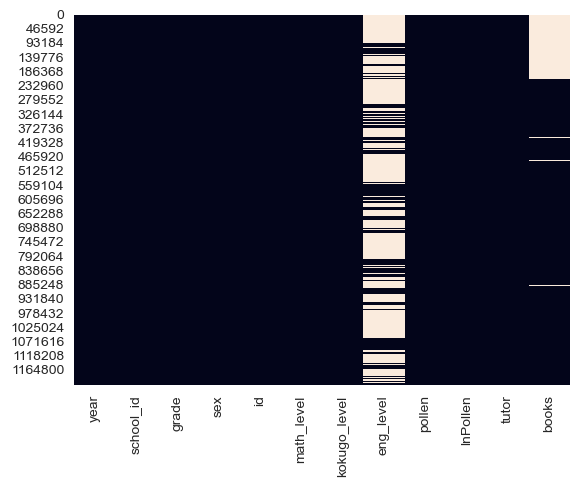

In [10]:
# book missing heatmap
sns.heatmap(df.isna(), cbar=False)

↑ missing values in books seem to be lower ID (not missing radnomly)
- eng exam score is missing a lot because those exams are taken by studnets who are in junior high school (grade 7-9) and not all students take the exam
- books are missing because they implimented the question after some year

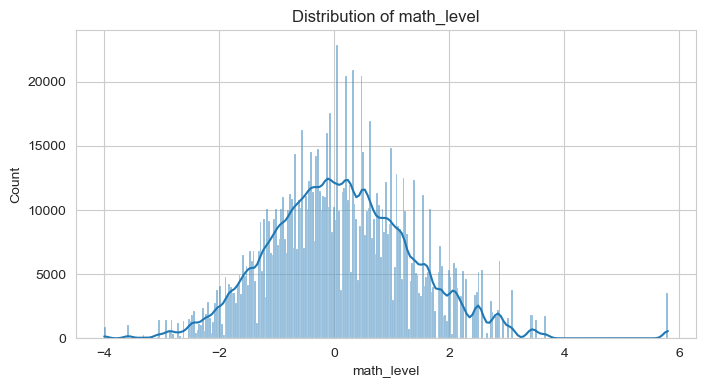

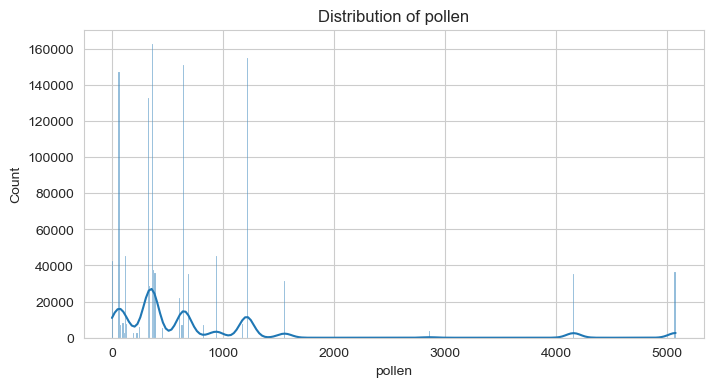

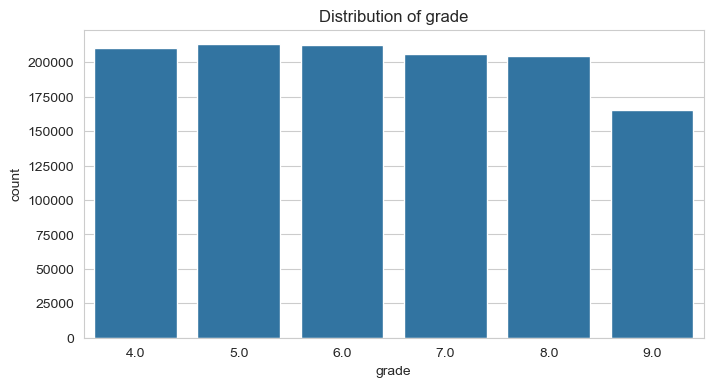

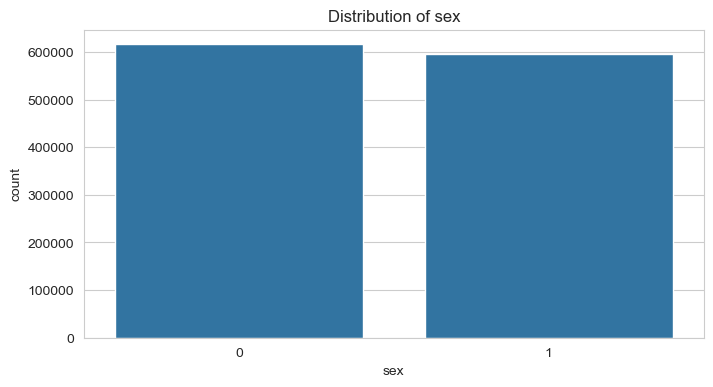

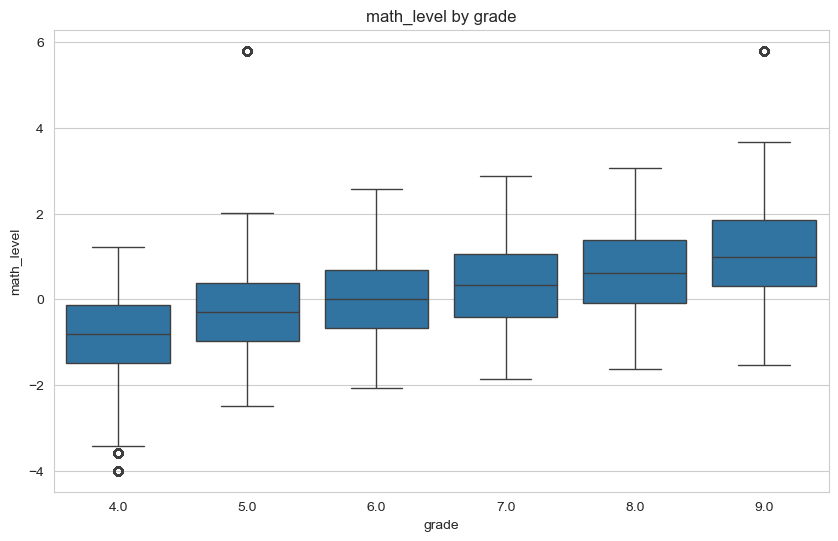

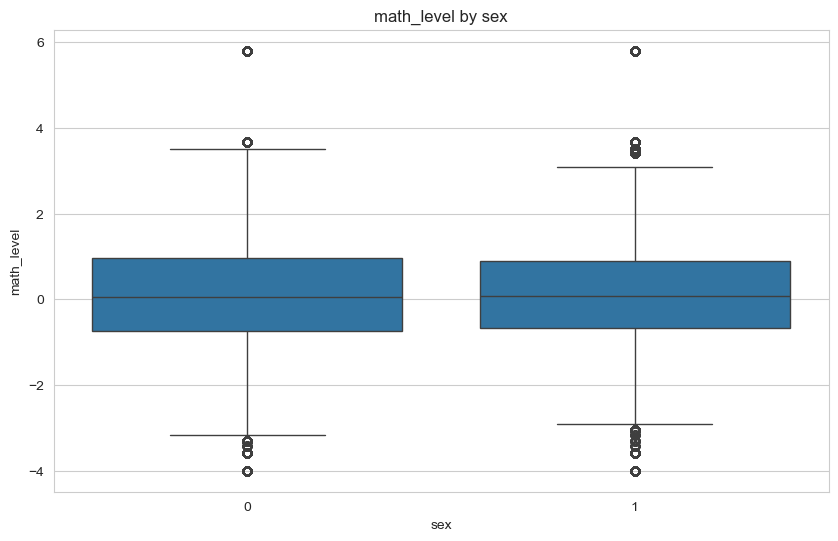

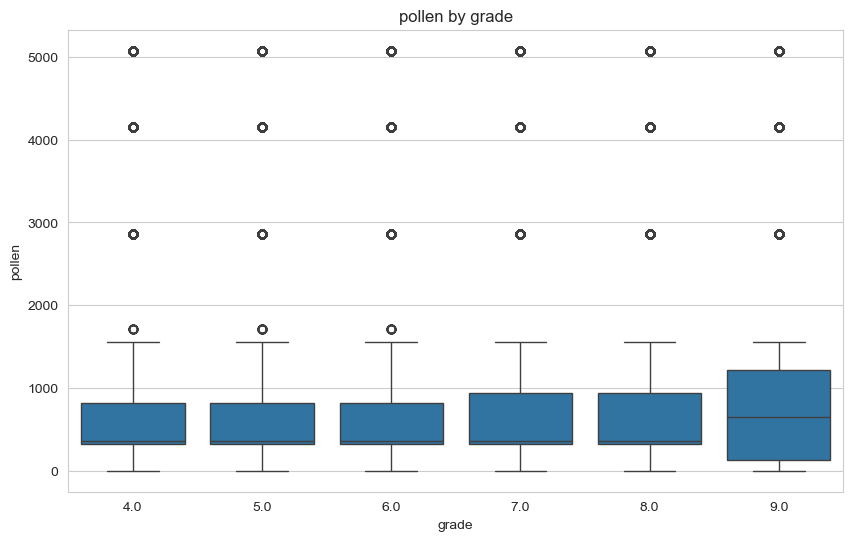

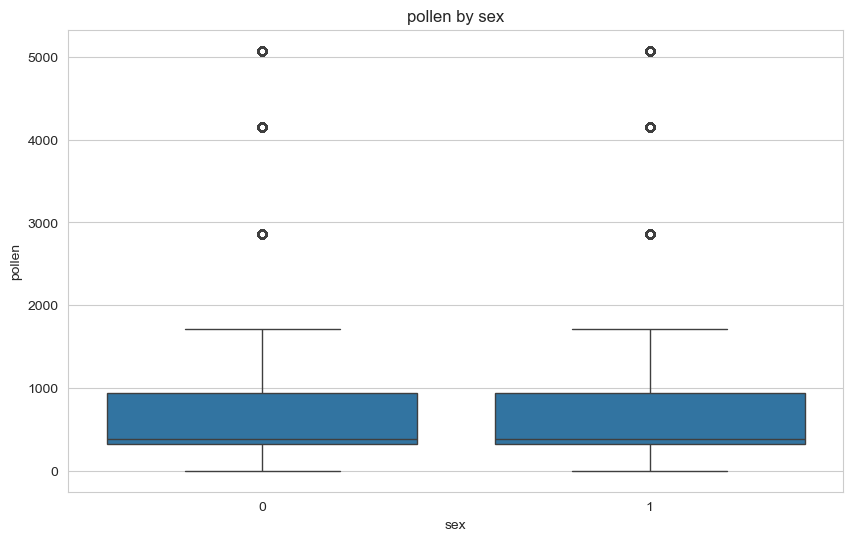

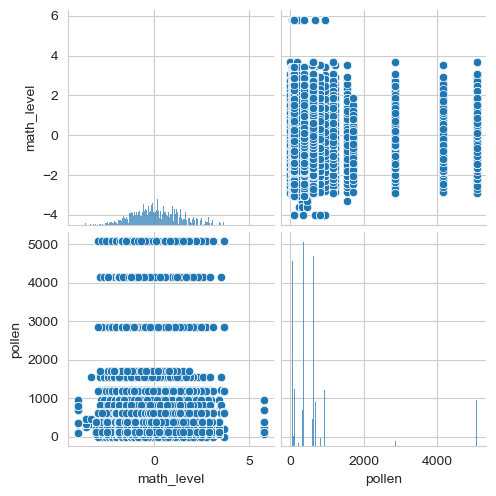

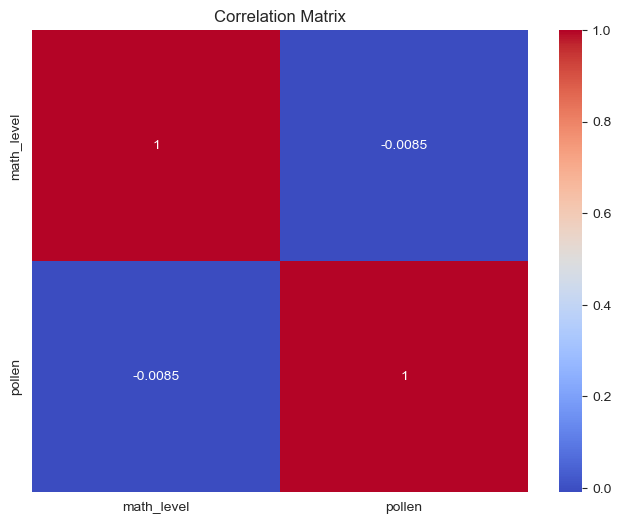

In [284]:
# Histograms for distributions
num_vars = ['math_level', 'pollen']
cat_vars = ['grade', 'sex']

# Plot distributions for numeric variables
for col in num_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Count plots for categorical variables
for col in cat_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box plots for numeric variables against categorical variables (sex and grade)
for num_var in num_vars:
    for cat_var in cat_vars:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=cat_var, y=num_var, data=df)
        plt.title(f'{num_var} by {cat_var}')
        plt.show()

# Pair plot to visualize the relationships between numeric variables
sns.pairplot(df[num_vars])
plt.show()

# Heatmap to visualize the correlation matrix
corr_matrix = df[num_vars].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**the data shows that the math score increases as the grade increases. This is because each question has difficulties with standard scaling across all the grades, so it is natural that students' score increase as they get older since they naturally solve more difficult questions**

--> this might cause problem in overall treatment effect. 

<Axes: ylabel='pollen'>

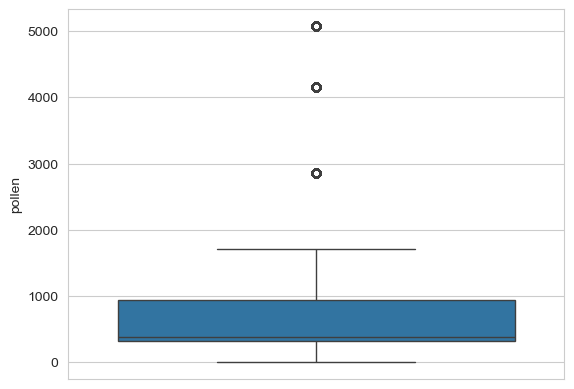

In [8]:
# distribution of pollen
sns.boxplot(df['pollen'])

↑　Consider removing outliers and or log transform the pollen variable

<Axes: xlabel='lnPollen', ylabel='Count'>

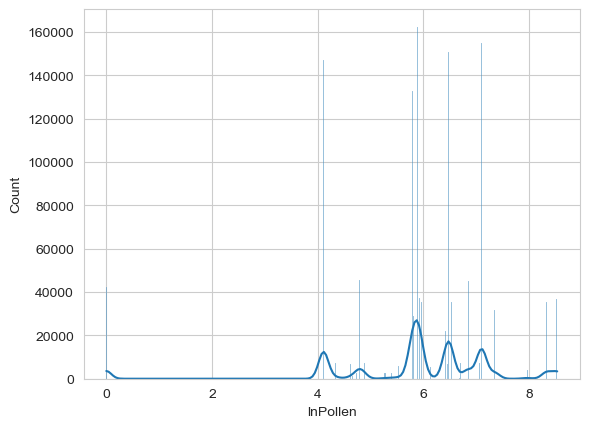

In [285]:
# distribution of log transform pollen (this accounts for the skewness of pollen and outliers)
sns.histplot(df['lnPollen'], kde=True)

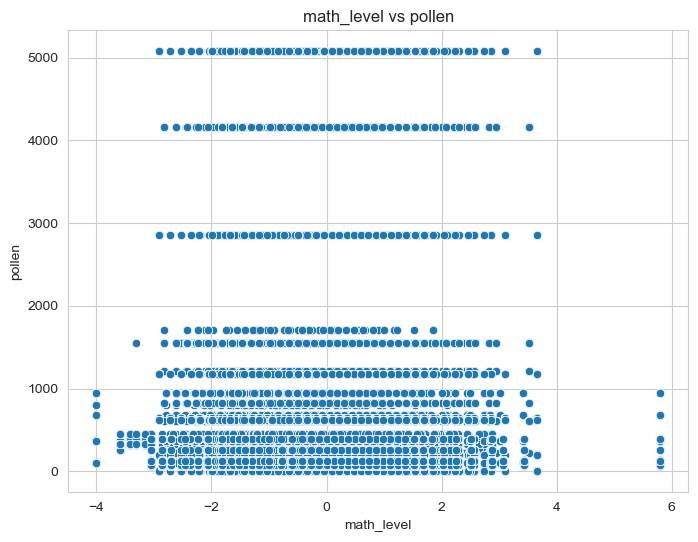

In [286]:
# Scatter plots for numeric variable relationships
for i in range(len(num_vars)):
    for j in range(i+1, len(num_vars)):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=num_vars[i], y=num_vars[j], data=df)
        plt.title(f'{num_vars[i]} vs {num_vars[j]}')
        plt.show()

↑　no clear relationship between pollen and math score

### Data Preprocessing

In [4]:
df2 = df.copy()

In [11]:
# remove pollen outliers: pollen more than 2000
# df2 = df2[df2['pollen'] < 2000]

<Axes: xlabel='pollen', ylabel='Count'>

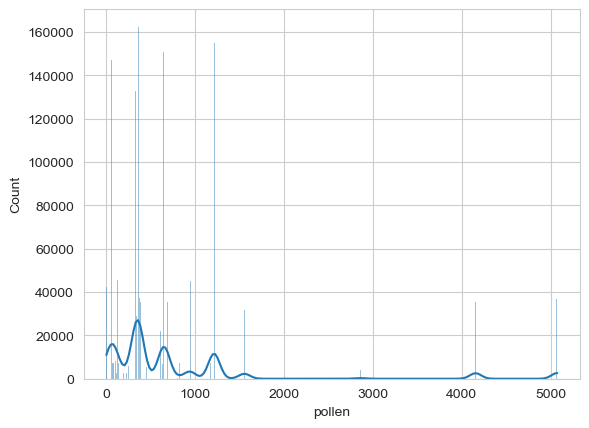

In [42]:
sns.histplot(df2['pollen'], kde=True)

In [5]:
df2.sort_values(by=['id', 'year'], inplace=True)
df2.reset_index(drop=True, inplace=True)
                

In [6]:
# how many times same id appear?
df.groupby('id').size().value_counts()

2    95719
3    95350
4    82075
5    70267
1    54239
7        1
6        1
Name: count, dtype: int64

In [8]:
df.groupby('year').size()


year
2015    206902
2016    252607
2017    253514
2018    250860
2019    247492
dtype: int64

In [40]:
from econml.panel.dml import DynamicDML

# Define the treatment, outcome, and covariates
treatment = ['pollen']

# chenge this to other subject as you wish
outcome = ['math_level']

# for now let's drop books, temp, rain
# do not need nearby_st as we already include school_id (shcool_id correlates with the Treatment - exposure to pollen and the outcome - test score)
covariates = ['school_id', 'grade', 'sex']
# covariates = ['year', 'grade', 'sex', 'tutor']
# covariates = ['grade', 'sex', 'tutor']

controls = ['tutor']


# drop missing values
df2 = df2.dropna(subset=outcome+covariates).copy()

In [41]:
# make it a balanced panel
# Get only those entities with the  number of observations
df2_balanced = df2.groupby('id').filter(lambda x: len(x) == 5)

In [42]:
# Prepare your data for the model
X = df2_balanced[covariates]
T = df2_balanced[treatment]
Y = df2_balanced[outcome]
W = df2_balanced[controls]

In [43]:
from sklearn.preprocessing import OrdinalEncoder

# # dummify the year
# X['year'] = X['year'].astype(str)
# X = pd.get_dummies(X)

ord_enc = OrdinalEncoder()
X['grade'] = ord_enc.fit_transform(X[['grade']])

import category_encoders as ce
encoder = ce.TargetEncoder(cols=['school_id'], handle_unknown='value')
X['school_id'] = encoder.fit_transform(X['school_id'], Y)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcastin

### Causal Model Building

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize DynamicDML with Linear Regression for the outcome and XGBRegressor for the treatment
estimator = DynamicDML(model_y=XGBRegressor(),
                       model_t=XGBRegressor(),
                       discrete_treatment=False)

In [45]:
Y = Y.values.ravel()  # Converts Y to a 1D array if Y is a DataFrame column

In [46]:
# Fit the model
# Note: Y, T, and X are the outcome, treatment, and covariates respectively
# Extract the index (group IDs) into a separate variable
groups = df2_balanced.id
# Fit the model
estimator.fit(Y, T, W=W, X=X, groups=groups)


In [47]:
causal_effects = estimator.effect(X)

In [48]:
estimator.cate_feature_names()

['school_id', 'grade', 'sex']

### Feature Importance

In [32]:
estimator.model_y.feature_importances_

NotFittedError: need to call fit or load_model beforehand

- I went through the documentation and all but I could not find a way to get the feature importance for DynamicDML

### Estimating the Causal Effect

In [49]:
effects_df = pd.DataFrame(causal_effects, columns=['Estimated Effect'])

# Analyze the estimated effects
print(effects_df.describe())

       Estimated Effect
count     351225.000000
mean           0.000292
std            0.000625
min           -0.001416
25%           -0.000225
50%            0.000295
75%            0.000809
max            0.003337


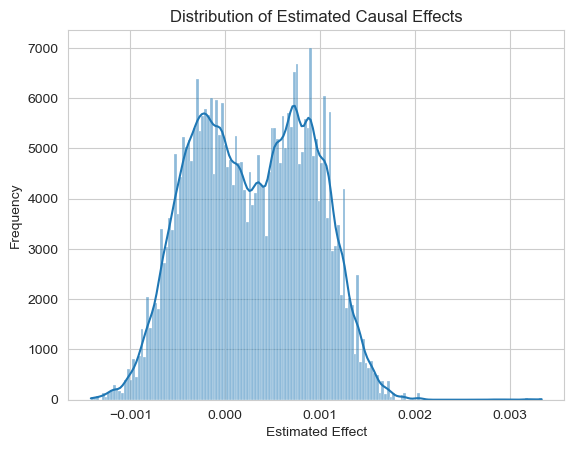

In [50]:
sns.histplot(effects_df['Estimated Effect'], kde=True)
plt.title('Distribution of Estimated Causal Effects')
plt.xlabel('Estimated Effect')
plt.ylabel('Frequency')
plt.show()

** The effect distribution seems to be M-shaped. It could be that students with seasonal pollen allergy vs without such allergy **

### Heterogeneity

In [51]:
df2_balanced['Estimated Effect'] = effects_df['Estimated Effect']
# will present this later in the notebook with other model settings

### Experiment more with the model

In [52]:
def fit_dynamic_dml(data, treatment, outcome, covariates, controls, group_col,
                    model_y, model_t, balance=True, balance_count=5):
    from sklearn.preprocessing import OrdinalEncoder
    import category_encoders as ce
    from econml.panel.dml import DynamicDML

    # Copy and sort data
    df = data.copy()
    df.sort_values(by=[group_col, 'year'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    df = df.dropna(subset=outcome+covariates)
    
    # Optionally balance the panel
    if balance:
        df = df.groupby(group_col).filter(lambda x: len(x) == balance_count)

    # Prepare data
    X, T, Y = df[covariates], df[treatment], df[outcome]
    W = df[controls] if controls else None

    # Encode features
    ord_enc = OrdinalEncoder()
    X['grade'] = ord_enc.fit_transform(X[['grade']])

    encoder = ce.TargetEncoder(cols=['school_id'], handle_unknown='value')
    X['school_id'] = encoder.fit_transform(X['school_id'], Y)

    # Initialize and fit DynamicDML
    estimator = DynamicDML(model_y=model_y, model_t=model_t, discrete_treatment=False)
    Y = Y.values.ravel()
    groups = df[group_col]
    estimator.fit(Y, T, W=W, X=X, groups=groups)

    return estimator


import seaborn as sns
import matplotlib.pyplot as plt

def plot_cate_subgroups(df, subgroup_col, cate_col):
    """
    Plots the distribution of CATE estimates for different subgroups.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    subgroup_col (str): Column name for the subgroup variable.
    cate_col (str): Column name for the CATE estimates.
    """
    unique_subgroups = df[subgroup_col].unique()

    plt.figure(figsize=(10, 6))
    for subgroup in unique_subgroups:
        sns.histplot(df[df[subgroup_col] == subgroup][cate_col], label=f'{subgroup_col}: {subgroup}', kde=True)

    plt.title(f'Distribution of {cate_col} by {subgroup_col}')
    plt.xlabel(cate_col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()



### Experiment 1: Linear Regression for the Outcome and XGBRegressor for the Treatment
- no log of pollen

First Setting (Linear Regression for Y, XGBRegressor for T, no log transform): This model assumes a linear relationship between the covariates and the outcome, which may be easier to interpret and justify if the relationship is indeed linear. However, it may miss non-linearities.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcastin

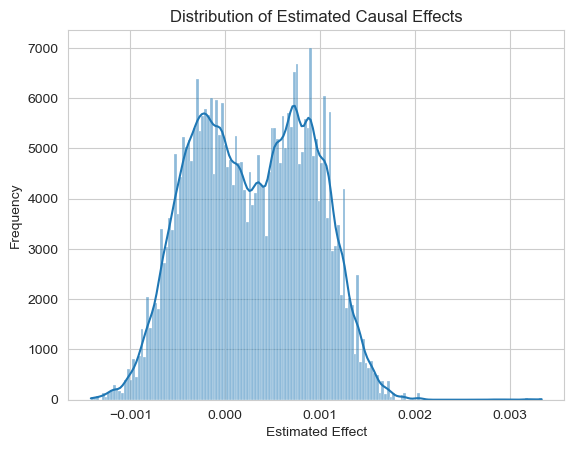

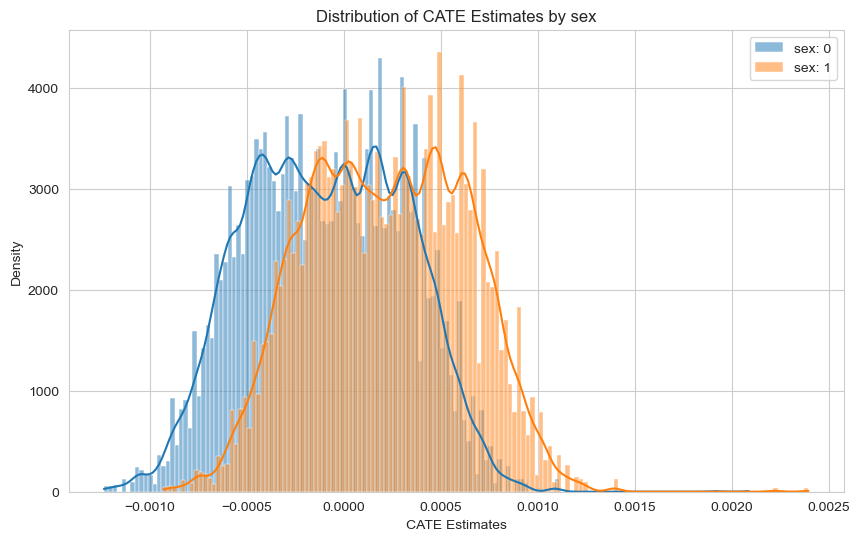

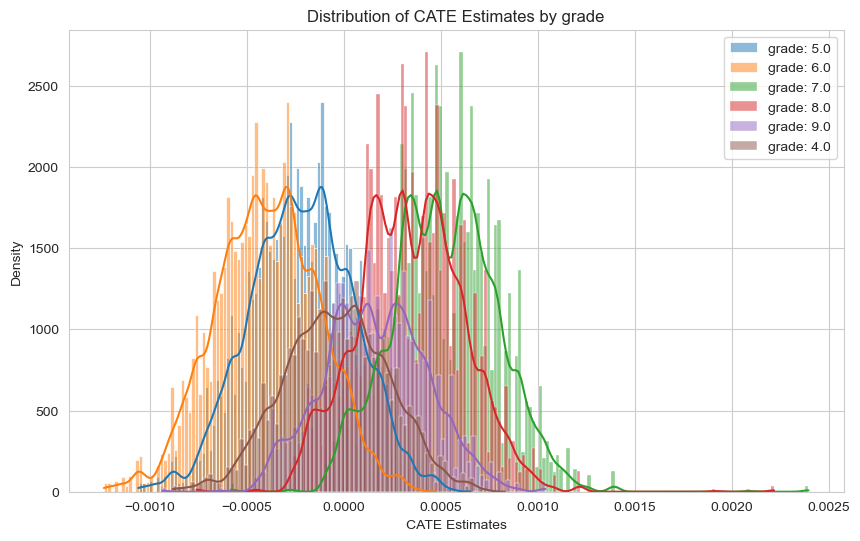

In [53]:

estimator = fit_dynamic_dml(
    df2,
    treatment=['pollen'],
    outcome=['math_level'],
    covariates=['school_id', 'grade', 'sex'],
    controls=['tutor'],
    group_col='id',
    model_y=LinearRegression(),
    model_t=XGBRegressor()
)

effects_df = pd.DataFrame(causal_effects, columns=['Estimated Effect'])
sns.histplot(effects_df['Estimated Effect'], kde=True)
plt.title('Distribution of Estimated Causal Effects')
plt.xlabel('Estimated Effect')
plt.ylabel('Frequency')
plt.show()

cate_estimates = estimator.effect(X)

# Adding the CATE estimates to your DataFrame
df2_balanced['CATE Estimates'] = cate_estimates

# Example: Plotting CATE estimates distribution by sex
plot_cate_subgroups(df2_balanced, 'sex', 'CATE Estimates')
# Example: Plotting CATE estimates distribution by grade
plot_cate_subgroups(df2_balanced, 'grade', 'CATE Estimates')

### Experiment 2: Linear Regression for the Outcome and XGBRegressor for the Treatment 
- Treatment is log of pollen

Second Setting (Linear Regression for Y, XGBRegressor for T, log transform): The log transformation here may help if the treatment variable is right-skewed. It normalizes the treatment distribution but retains a simple linear model for the outcome, potentially providing a balance between capturing non-linearities in the treatment while maintaining interpretability for the outcome.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcastin

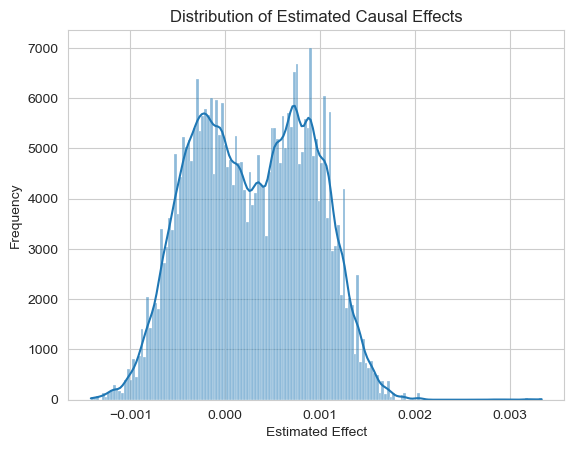

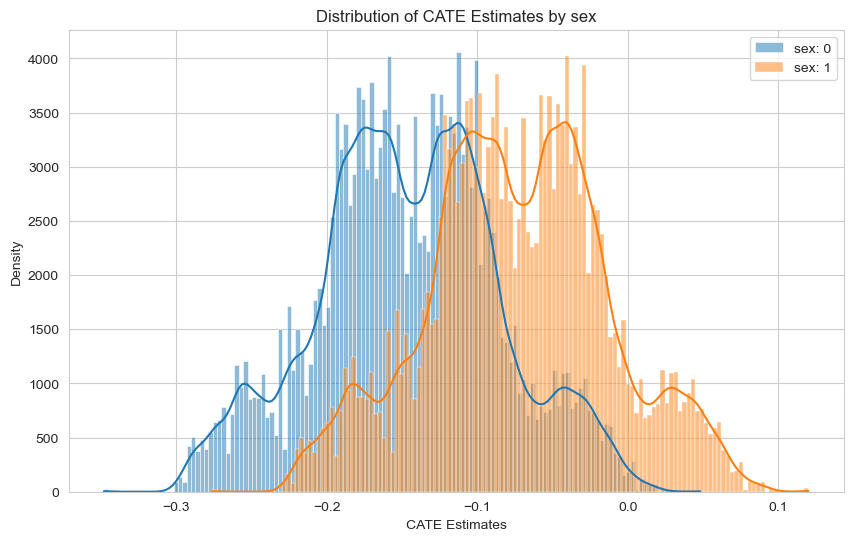

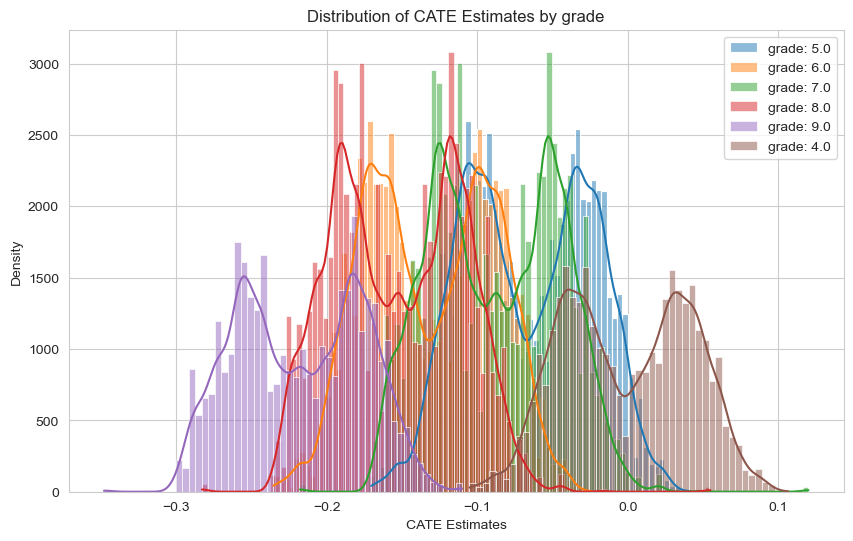

In [54]:
estimator = fit_dynamic_dml(
    df2,
    treatment=['lnPollen'],
    outcome=['math_level'],
    covariates=['school_id', 'grade', 'sex'],
    controls=['tutor'],
    group_col='id',
    model_y=LinearRegression(),
    model_t=XGBRegressor()
)

effects_df = pd.DataFrame(causal_effects, columns=['Estimated Effect'])
sns.histplot(effects_df['Estimated Effect'], kde=True)
plt.title('Distribution of Estimated Causal Effects')
plt.xlabel('Estimated Effect')
plt.ylabel('Frequency')
plt.show()

cate_estimates = estimator.effect(X)

# Adding the CATE estimates to your DataFrame
df2_balanced['CATE Estimates'] = cate_estimates

# Example: Plotting CATE estimates distribution by sex
plot_cate_subgroups(df2_balanced, 'sex', 'CATE Estimates')
# Example: Plotting CATE estimates distribution by grade
plot_cate_subgroups(df2_balanced, 'grade', 'CATE Estimates')

### Experiment 3: XGBRegressor for the Outcome and XGBRegressor for the Treatment
- no log of pollen

Third Setting (XGBRegressor for both Y and T, no log transform): This is the most flexible model, able to capture complex non-linearities. It may be the best choice if the underlying relationship is believed to be highly non-linear.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcastin

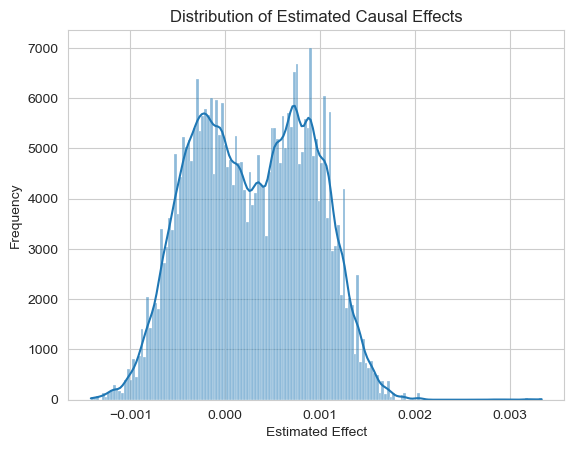

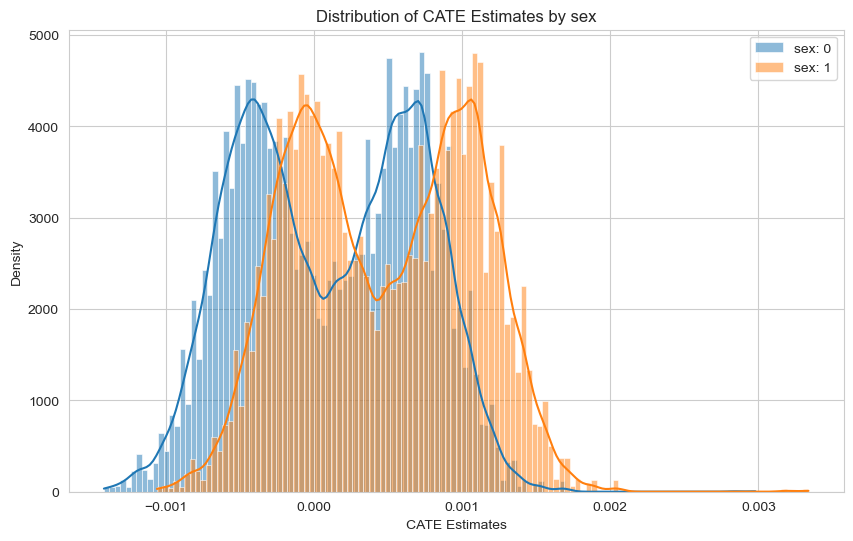

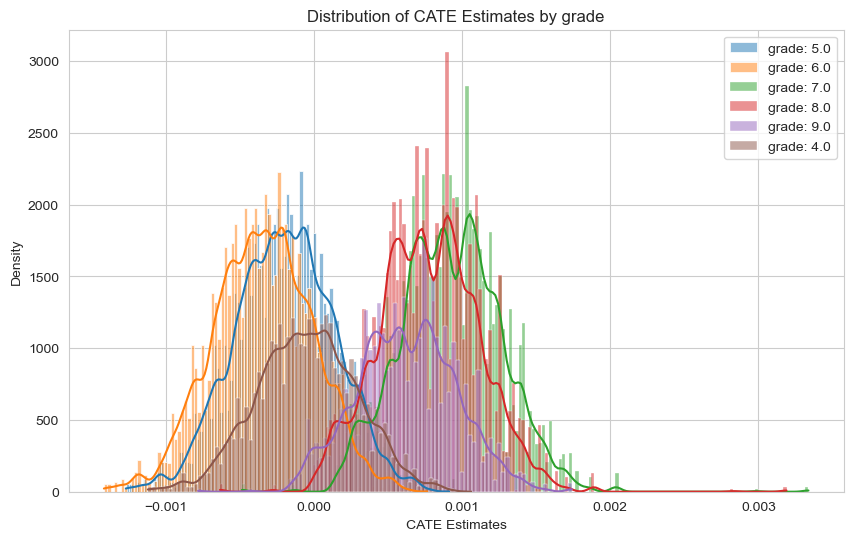

In [55]:
estimator = fit_dynamic_dml(
    df2,
    treatment=['pollen'],
    outcome=['math_level'],
    covariates=['school_id', 'grade', 'sex'],
    controls=['tutor'],
    group_col='id',
    model_y=XGBRegressor(),
    model_t=XGBRegressor()
)

effects_df = pd.DataFrame(causal_effects, columns=['Estimated Effect'])
sns.histplot(effects_df['Estimated Effect'], kde=True)
plt.title('Distribution of Estimated Causal Effects')
plt.xlabel('Estimated Effect')
plt.ylabel('Frequency')
plt.show()

cate_estimates = estimator.effect(X)

# Adding the CATE estimates to your DataFrame
df2_balanced['CATE Estimates'] = cate_estimates

# Example: Plotting CATE estimates distribution by sex
plot_cate_subgroups(df2_balanced, 'sex', 'CATE Estimates')
# Example: Plotting CATE estimates distribution by grade
plot_cate_subgroups(df2_balanced, 'grade', 'CATE Estimates')

### Experiment 4: XGBRegressor for the Outcome and XGBRegressor for the Treatment
- Treatment is log of pollen

Fourth Setting (XGBRegressor for both Y and T, log transform): This setting offers the most flexibility and is best suited for capturing complex, non-linear relationships, especially when combined with the log transform that addresses skewness in the treatment variable.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcastin

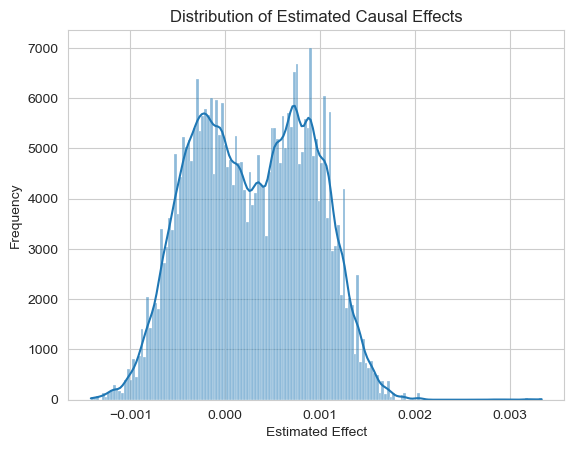

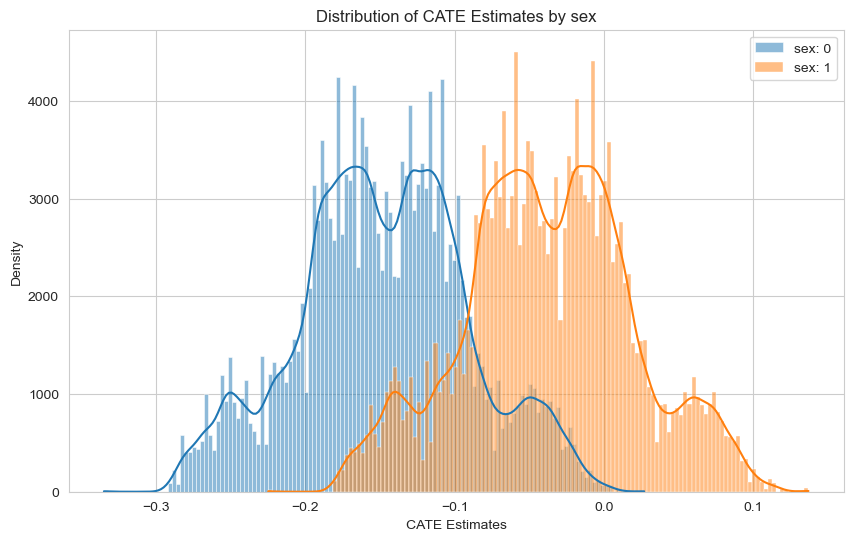

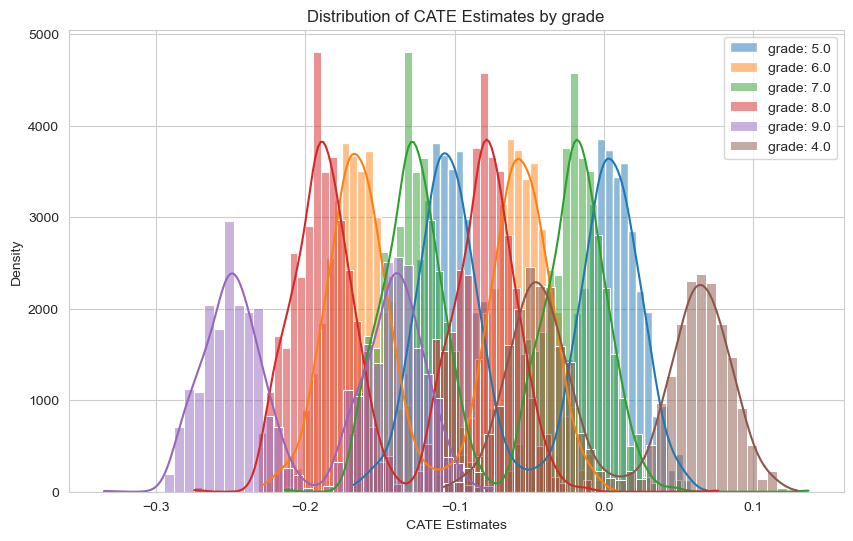

In [56]:
estimator = fit_dynamic_dml(
    df2,
    treatment=['lnPollen'],
    outcome=['math_level'],
    covariates=['school_id', 'grade', 'sex'],
    controls=['tutor'],
    group_col='id',
    model_y=XGBRegressor(),
    model_t=XGBRegressor()
)

effects_df = pd.DataFrame(causal_effects, columns=['Estimated Effect'])
sns.histplot(effects_df['Estimated Effect'], kde=True)
plt.title('Distribution of Estimated Causal Effects')
plt.xlabel('Estimated Effect')
plt.ylabel('Frequency')
plt.show()

cate_estimates = estimator.effect(X)

# Adding the CATE estimates to your DataFrame
df2_balanced['CATE Estimates'] = cate_estimates

# Example: Plotting CATE estimates distribution by sex
plot_cate_subgroups(df2_balanced, 'sex', 'CATE Estimates')
# Example: Plotting CATE estimates distribution by grade
plot_cate_subgroups(df2_balanced, 'grade', 'CATE Estimates')

### Justification for Choosing the Final (Forth) Model

If the treatment variable's distribution justifies a log transformation due to skewness or outliers, and if the relationships in the data are indeed non-linear (which the domain knowledge and data exploration should indicate), the fourth setting could be the best choice. It combines the benefits of normalization with the ability to capture complex relationships. However, it is also the least interpretable due to the black-box nature of XGBRegressor.

###  Hypothesis and Interpret the outcome

**Assumptions**
- Some students with pollen allergy might take medicine to reduce the effect of pollen on test score
- The effect of pollen on test score is not linear
- The model does not suffer from omitted variable bias (assumes uncounfoundedness and pollen variable is exogenous) 

**Hypothesis**
- Pollen has a negative effect on test score
- Pollen has a negative effect on test score for students with pollen allergy
- Pollen has a less or no effect on test score for students without pollen allergy

- There are heterogeneity between genders and grades
    - gender: some men would be more explosed to pollen due to their lifestyles (on average activce outdoor)
    - grade: older students might be more affected by pollen as they are more likely to have pollen allergy 
    - or they might be less affected by pollen as they are more likely to take medicine to reduce the effect of pollen on test score + they are able to take more strong medicine than younger students such as anti-histamine


### Interpretation of the result

**Overall Estimated Causal Effects:**
The first graph shows the overall distribution of the estimated causal effects. The majority of the estimates cluster around zero, suggesting that for the entire sample, the average effect of pollen exposure on math test scores is minimal or indiscernible. This could imply that pollen does not have a strong effect on math scores for the general student population when not considering heterogeneity.

→ however, As the grade increases, the math score increases as well. This is because each question has difficulties with standard scaling across all the grades, so it is natural that students' score increase as they get older since they naturally solve more difficult questions. This may be causing bias in the overall treatment effect.


We can see that the distribution is M shape. This could be due to the fact that some students have seasonal pollen allergy and some do not. This could be the reason why the distribution is M shape.



**CATE Estimates by Sex:**
The second graph divides the CATE by sex, represented by two peaks – one for sex 0 male and one for sex 1 female. There appears to be a more pronounced negative effect in male compared to the other, which is shifted slightly towards the negative side of the effect axis. This is in line with the hypothesis that there might be heterogeneity between genders, suggesting that lifestyle or biological differences might cause variations in susceptibility to pollen and its impact on concentration during tests.





**CATE Estimates by Grade:**
The third graph shows the distribution of CATE across different grades, indicating substantial heterogeneity. Each grade appears to have a distinct distribution, with some grades showing a more pronounced negative effect (e.g., grades 6, 7, and possibly 8), while others are more centered around zero. This opposes the hypothesis that older students (higher grades) might be more or less affected by pollen, possibly due to increased allergy prevalence or medication use. It's notable that the distributions are not symmetric, suggesting non-linear effects and potential thresholds where the impact of pollen becomes more pronounced. Additionally, it follows the M shape as seen in the overall distribution, which could be due to the same reasons.





**Insights and Comparisons with Hypotheses:**
1. **Pollen and Math Scores**: The data doesn't show a strong overall effect of pollen on math scores (this effect could be significant depending on the standardized method used on the test score data - as the range is approximately -6 to 6 ); however, there is evidence of heterogeneity when considering gender and grade, which aligns with your hypothesis.
2. **Pollen Allergy Medication**: If some students with pollen allergies are medicating, this could be damping the overall effect and contributing to the heterogeneity observed. This could explain why the average effect is close to zero but varies by subgroup.
3. **Non-Linear Effects**: The varied distribution shapes across grades suggest that the relationship between pollen exposure and test scores is indeed non-linear, with the effect potentially changing at different levels of exposure.
4. **Omitted Variable Bias**: There's no direct evidence from these visuals about omitted variable bias. If critical confounders are unaccounted for, the estimates could be biased. For instance, if some students spend more time outdoors than others, this could confound the relationship between pollen exposure and math scores.
5. **Heterogeneity**: The hypothesis about heterogeneity seems supported, indicating that gender and grade level do influence the effect of pollen on test scores. The lifestyle or biological differences (such as puberty onset) could be driving these variations.

**Inference:**
The most significant insight is the presence of heterogeneity. While the overall effect of pollen on math scores is negligible, subgroups defined by gender and grade show varying degrees of negative impact. This suggests that interventions or policies designed to mitigate the effects of pollen should be targeted rather than universal, focusing on those groups most negatively impacted. Further analysis, perhaps using interaction terms or subgroup analysis in regression models, could provide more precise estimates of these effects and validate the observations from these graphs. It's also important to consider the potential for confounding factors that may affect both exposure to pollen and math scores, such as socio-economic status, time spent outdoors, and school environment, which could influence the estimates of the causal effect.

### Limitations and Future Work

### Limitations

1. **Measurement Error in Pollen Levels**: The use of station-level pollen measurements introduces potential measurement error, especially if schools are located at varying distances from the monitoring stations. This spatial discrepancy can lead to misclassification of actual pollen exposure for individual students, thereby biasing the estimated effects.

2. **Unobserved Medicine Intake**: If students are taking medication to alleviate allergy symptoms, this self-treatment could attenuate the observed relationship between pollen levels and test scores. Since medication intake is not observed in the data, the effect of pollen on test scores might be systematically underestimated.

### Further Work

To address these limitations, future research could take several directions:

1. **Refined Measurement of Pollen Exposure**: Collecting more granular data on pollen levels, such as using school-based sensors or incorporating geographic information systems (GIS) to estimate pollen counts more precisely at the school or even individual level, could reduce measurement error.

2. **Data on Medication Intake**: Incorporating data on allergy medication intake would allow for a more accurate estimation of the true effect of pollen exposure. This could involve surveying students or linking health records to the educational data, subject to privacy considerations and consent.

3. **Instrumental Variable Analysis**: If a valid instrument could be found (e.g., day-to-day variations in pollen levels that are independent of individual behaviors), it could be used to mitigate the bias from unobserved confounders such as medication intake.

4. **Longitudinal Analysis**: A longitudinal study design could help track the changes in individual students' test scores over time relative to pollen levels and medication use. This could provide a clearer picture of the causal pathways.

5. **Subgroup Analysis by Distance from Pollen Stations**: Analyzing the effects of pollen on test scores by stratifying schools based on their distance from the nearest pollen measurement station could reveal the extent of the measurement error.

6. **Policy Intervention Studies**: Experimental or quasi-experimental designs, such as randomized provision of air filtration systems in schools, could offer more robust evidence on the causal impact of pollen exposure on educational outcomes.

7. **Extension to Other Outcomes**: Exploring the effect of pollen exposure on other outcomes, such as physical activity or school attendance, could provide a more comprehensive understanding of its broader impacts on student well-being and performance.
